In [1]:
import numpy as np
import pandas as pd

import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from oauth2client.service_account import ServiceAccountCredentials

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib_venn import venn2, venn3, venn3_circles
from pandas.plotting import parallel_coordinates

import powerlaw
from scipy import stats
from scipy.optimize import curve_fit

from tqdm.auto import tqdm
tqdm.pandas()

In [2]:
# Implementation of partial log binning
def thresh(bin_size):
    x = 1
    while True:
        diff = np.log10(x+1) - np.log10(x)
        if diff < bin_size:
            return x +1
        x = x + 1

def partial_log_binning(data_counts, bin_size=0.1):
    n_bins = 1/bin_size
    binning_threshold = thresh(bin_size)

    log_data = np.log10(data_counts)
    log_index = np.log10(log_data.index)

    logbins = np.linspace(np.log10(binning_threshold)+0.1,
                          np.log10(max(data)),
                          ((np.log10(max(data))-np.log10(binning_threshold)+0.1)//0.1)+1)

    binned_xs = []
    binned_vals = []      
    
    for i in range(1, binning_threshold+1):      
        if i in log_data.index:
            binned_vals.append(log_data.loc[i])
            binned_xs.append(np.log10(i))
    
    for b in logbins:       
            vals = (b-.05 <= log_index) & (log_index < b+.05)
            vs = data_counts[vals]
            if len(vs)>0:
                n = np.ceil(10**(b+.05) - 10**(b-.05))
                if n == 0:
                    continue
                binned_vals.append(np.log10(vs.sum()/n))
                binned_xs.append(b)
    return binned_xs, binned_vals  

# Configuration

In [3]:
plt.rcParams.update({
    'font.family':'sans-serif',
    'font.size': 16.0,
    'text.usetex': False,
    'figure.figsize': (11.69,8.27)
})

# Seaborn styles
sns.set_style("whitegrid")

# Color palette
cm = "Paired"
cp3 = sns.color_palette(cm, 3)
cp10 = sns.color_palette(cm, 10)

In [4]:
# Set up GSpread connection
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

credentials = ServiceAccountCredentials.from_json_keyfile_name('My Project-d9fa71152fe8.json', scope)

gc = gspread.authorize(credentials)
sh =  gc.open("PLOS Paper - Tables")

# Load data, preprocessing, dropping years + bad results

In [5]:
articles_csv = "data/articles.csv"
responses_csv = "data/responses.csv"  

In [6]:
articles = pd.read_csv(articles_csv, index_col="doi", parse_dates=['publication_date'])
responses = pd.read_csv(responses_csv, index_col="id", parse_dates=['received_at', 'og_updated_time', 'publication_date', 'added_on'])

# add year
responses = responses.merge(articles[['year']], left_on="doi", right_index=True, how="left")

In [7]:
all_shares = set(articles['AES'].dropna().index.tolist())
all_reactions = set(articles['AER'].dropna().index.tolist())
all_comments = set(articles['AEC'].dropna().index.tolist())

am_shares = set(articles['POS'].dropna().index.tolist())
twitter_set = set(articles['TW'].dropna().index.tolist())

any_shares = am_shares.union(all_shares)
both_shares = am_shares.intersection(all_shares)
any_engagement = all_shares.union(all_reactions).union(all_comments)

In [8]:
metrics = ['AES', 'POS', 'TW']

In [9]:
print(len(all_shares))
print(len(all_reactions))
print(len(all_comments))

21415
13825
10259


# Results

## Nature of All-Engagement Data

In [16]:
# Limit responses to those articles that received some forms of engagement
nz_resp = responses
nz_resp = nz_resp.replace(0, np.nan)
nz_resp = nz_resp.dropna(subset=['shares', 'reactions', 'comments'], how="all")

print("OG URLs: {}".format(responses.shape[0]))
print("Non-zero eng: {}".format(nz_resp.shape[0]))
print("Dropped: {}".format(responses.shape[0]-nz_resp.shape[0]))
print("Unique URLs:", nz_resp.url.nunique())
print("Unique DOIs:", nz_resp.doi.nunique())

OG URLs: 69948
Non-zero eng: 32887
Dropped: 37061
Unique URLs: 32887
Unique DOIs: 21674


In [17]:
cov_urls_counts = nz_resp[['doi', 'og_id']].groupby("doi").count().og_id.value_counts().reset_index()
cov_urls_counts['%'] = 100 * cov_urls_counts.og_id.div(cov_urls_counts.og_id.sum())
cov_urls_counts.columns = ["Number of URLs", "Articles", "Articles [%]"]

cov_urls_counts = cov_urls_counts.set_index("Number of URLs")

if False:
    wks = sh.worksheet("Coverage - Number of URLs")
    set_with_dataframe(wks, cov_urls_counts.round(1).reset_index())

cov_urls_counts.round(1)

,Articles,Articles [%]
Number of URLs,,
1,12344,57.0
2,7702,35.5
3,1442,6.7
4,142,0.7
5,29,0.1
6,8,0.0
7,4,0.0
8,3,0.0


In [18]:
x = nz_resp[['doi', 'og_id']].groupby("doi").nunique().og_id.value_counts().reset_index()
x['%'] = 100*x.og_id.div(x.og_id.sum())
x.columns = ["Objects per Article", "Articles", "Articles [%]"]
x = x.set_index("Objects per Article")
x.round(1)

,Articles,Articles [%]
Objects per Article,,
1,21134,97.5
2,539,2.5
3,1,0.0


In [19]:
x = nz_resp[['doi', 'og_id']].groupby("doi")["og_id"].nunique()
mult_ogids = x[x>1].keys()

y = nz_resp[nz_resp.doi.isin(mult_ogids)]
z = y[['doi', 'og_id', 'type']].groupby(["doi", "og_id"])['type'].apply(lambda x: ", ".join(sorted(x))).reset_index()
zz = z.groupby("doi")['type'].apply(lambda x: " -- ".join(sorted(x)))

zz.map(lambda x: "pdf" in x).sum()

504

In [20]:
cov_urls_types = nz_resp.type.value_counts().reset_index()
cov_urls_types['%'] = 100*cov_urls_types.type.div(cov_urls_types.type.sum())
cov_urls_types.columns = ["URL Type", "FB Objects", "FB Objects [%]"]

cov_urls_types = cov_urls_types.set_index("URL Type")

if False:
    wks = sh.worksheet("Coverage - URL Types")
    set_with_dataframe(wks, cov_urls_types.round(1).reset_index())

cov_urls_types.round(1)

,FB Objects,FB Objects [%]
URL Type,,
landing,21515,65.4
doi_old,4927,15.0
metrics,4348,13.2
doi,982,3.0
pdf,644,2.0
authors,296,0.9
related,96,0.3
comments,76,0.2
pmid,2,0.0


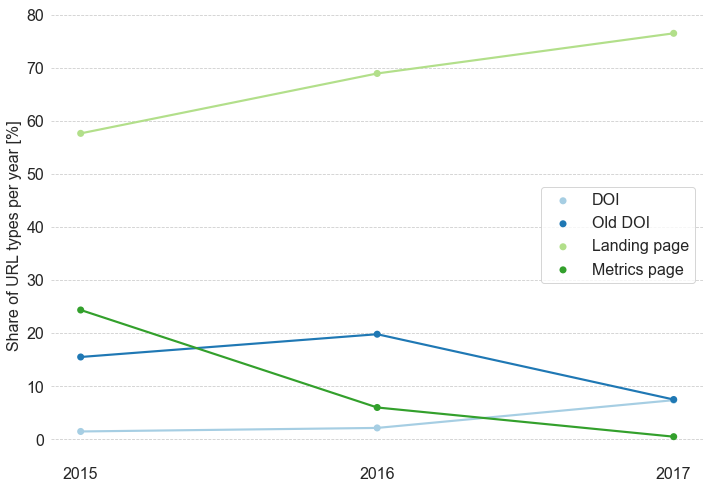

In [21]:
types_to_plot = ['landing', 'doi_old', 'doi', 'metrics']
nz_resp_years = nz_resp.year.value_counts()

pdf = nz_resp.groupby(['type', 'year']).size().to_frame('size').reset_index()
pdf = pdf[pdf['type'].isin(types_to_plot)]

pdf.columns = ["URL type", "Year", "Count"]

pdf['Share of URL types per year [%]'] = pdf.apply(lambda x: 100*x['Count']/nz_resp_years[x['Year']], axis=1)

pdf = pdf.replace({'doi': 'DOI',
                   'doi_old': 'Old DOI',
                   'landing': 'Landing page',
                   'metrics': 'Metrics page'})

sns.pointplot(x="Year", y="Share of URL types per year [%]", hue="URL type", data=pdf, palette=cm, scale=.8)

plt.xlim(-.1,2.1)
plt.xlabel("")

h, l = plt.gca().get_legend_handles_labels()
plt.legend(h, l)

plt.grid(False)
plt.grid(True, axis="y", linestyle="--")

sns.despine(left=True, right=True, top=True, bottom=True)

### Coverage of Shares, Reactions, and Comments

In [14]:
print(articles[['AES', 'AER', 'AEC']].dropna(how="all").shape[0])
articles.describe()

21674


,pmid,year,AES,POS,TW,AER,AEC
count,6.184300e+04,61848.000000,21415.000000,9623.000000,43064.000000,13825.000000,10259.000000
mean,2.721320e+07,2015.873642,8.811674,2.301465,8.923718,53.535335,23.989668
std,1.080284e+06,0.824578,136.323191,4.804324,63.637819,475.446702,311.972031
min,2.555500e+07,2015.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.624747e+07,2015.000000,1.000000,1.000000,1.000000,4.000000,2.000000
50%,2.701101e+07,2016.000000,2.000000,1.000000,3.000000,16.000000,6.000000
75%,2.815831e+07,2017.000000,4.000000,2.000000,6.000000,46.000000,15.000000
max,2.928712e+07,2017.000000,12473.000000,186.000000,8626.000000,36030.000000,15840.000000


In [15]:
disc_counts = base.dropna(how="any", subset=['AES', 'AER', 'AEC']).disc.value_counts()

x = base.dropna(how="any", subset=['AES', 'AER', 'AEC'])[['disc', 'AES', 'AER', 'AEC']]
x['AER/AES'] = x['AER'] / x['AES']
x['AEC/AES'] = x['AEC'] / x['AES']
x = x.melt(id_vars="disc", value_vars=['AEC/AES', 'AER/AES']).dropna()

meds = x.groupby(["disc", "variable"])['value'].median().reset_index().groupby('disc')['variable', 'value'].apply(lambda x: x.iloc[0,1])
x['sort'] = x.disc.map(lambda x: meds[x])

x.disc = x.disc.map(lambda x: "{} ({})".format(x, disc_counts[x]))
x = x.sort_values(["sort"])

sns.boxenplot(x="disc", y="value", hue="variable", data=x, palette=cm)

plt.yscale("log")
xmin, xmax = plt.gca().get_xlim()
plt.hlines(1, xmin, xmax, zorder=-1, color="red")

yticks = [0.1, 1, 2, 5, 10, 100, 1000]
plt.yticks(yticks, yticks);

plt.xticks(rotation=45, ha="right");
plt.xticks(rotation=90)

plt.xlabel("")
plt.ylabel("Ratio")

sns.despine(left=True, right=True, top=True, bottom=True)

NameError: name 'base' is not defined

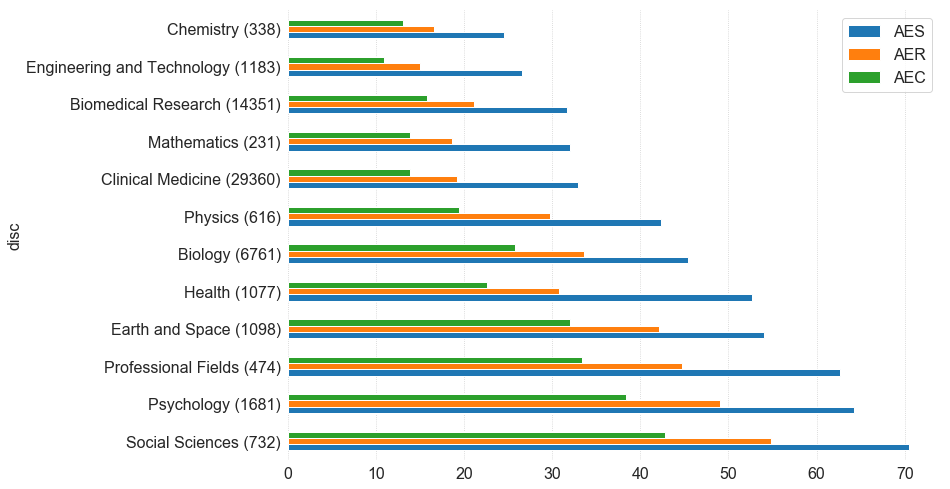

In [230]:
disc_counts = base.disc.value_counts()
x = base.groupby("disc")[['AES', 'AER', 'AEC']].count()
x = x.apply(lambda x: x.map(lambda y: 100*y/disc_counts[x.name]), axis=1)
x.index = x.index.map(lambda x: "{} ({})".format(x, disc_counts[x]))
x.sort_values("AES", ascending=False).plot(kind="barh")

plt.grid(False)
plt.grid(True, axis="x", linestyle=":")
sns.despine(left=True, top=True, right=True, bottom=True)

In [ ]:
disc_counts = base.disc.value_counts()
x = base.groupby("disc")[['AES', 'AER', 'AEC']].count()
# x = x.apply(lambda x: x.map(lambda y: 100*y/disc_counts[x.name]), axis=1)
x.index = x.index.map(lambda x: "{} ({})".format(x, disc_counts[x]))

x['AER/AES'] = 100 * x['AER'] / x['AES']
x['AEC/AES'] = 100 * x['AEC'] / x['AES']
x[['AER/AES', 'AEC/AES']].sort_values('AEC/AES', ascending=False).plot(kind="barh")

plt.ylabel("")
ticks = list(range(0, 81, 10))
plt.xticks(ticks, ["{:,}%".format(int(_)) for _ in ticks])

plt.grid(False)
plt.grid(True, axis="x", linestyle=":")
sns.despine(left=True, top=True, right=True, bottom=True)

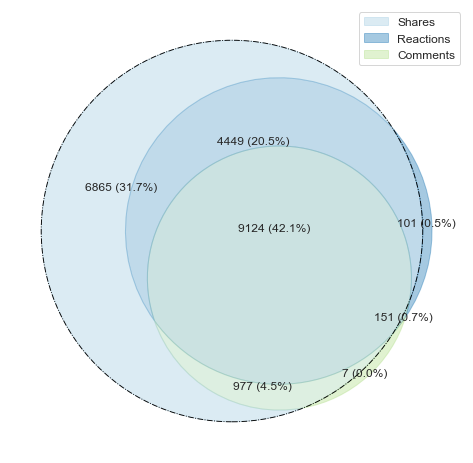

In [22]:
v = venn3(subsets= [all_shares, all_reactions, all_comments],
          set_labels=('', '', ''),
          subset_label_formatter=lambda x: "{} ({:.1f}%)".format(x, 100*x/len(any_engagement)));

c=venn3_circles(subsets= [all_shares, all_reactions, all_comments], linewidth=0)
c[0].set_lw(.9)
c[0].set_ls('-.')

v.get_patch_by_id('100').set_color(cp3[0])
v.get_patch_by_id('010').set_color(cp3[1])
v.get_patch_by_id('001').set_color(cp3[2])

v.get_patch_by_id('110').set_color(np.add(cp3[0],cp3[1])/2)
v.get_patch_by_id('011').set_color(np.add(cp3[1],cp3[2])/2)
v.get_patch_by_id('101').set_color(np.add(cp3[0],cp3[2])/2)

v.get_patch_by_id('111').set_color(np.add(np.add(cp3[1],cp3[0]), cp3[2]) / 3)

for text in v.set_labels:
    text.set_fontsize(12)
for text in v.subset_labels:
    text.set_fontsize(14)


for text in v.set_labels:
    text.set_fontsize(10)
for text in v.subset_labels:
    text.set_fontsize(12)

plt.gca().legend(handles=[v.get_patch_by_id('100'), v.get_patch_by_id('010'), v.get_patch_by_id('001')],
                 labels=["Shares", "Reactions", "Comments"], prop={'size': 12});

## Comparison of Methods

### Coverage

#### Comparison of AS, PS, and TW

In [23]:
x = articles[metrics + ['year']].groupby("year").count()
x['All articles'] = articles.groupby("year").count()['title']

df_cross_metrics = x.copy()
df_cross_metrics.loc['All years'] = df_cross_metrics.sum(axis=0)

for i in df_cross_metrics.index.tolist():
    df_cross_metrics.loc[i, metrics] = df_cross_metrics.loc[i, metrics].map(
        lambda x: "{:,} ({:.1f}%)".format(x, 100*x/df_cross_metrics.loc[i, 'All articles'])
    )

df_cross_metrics.index.name = ""

if True:
    wks = sh.worksheet("Coverage - Methods")
    set_with_dataframe(wks, df_cross_metrics.reset_index())
    
df_cross_metrics

,AES,POS,TW,All articles
,,,,
2015,"8,596 (33.8%)","3,981 (15.7%)","16,976 (66.8%)",25427
2016,"6,992 (37.2%)","3,058 (16.3%)","13,807 (73.4%)",18809
2017,"5,827 (33.1%)","2,584 (14.7%)","12,281 (69.7%)",17612
All years,"21,415 (34.6%)","9,623 (15.6%)","43,064 (69.6%)",61848


In [24]:
articles[['AES', 'POS', 'TW']].dropna(how="all").shape

(46286, 3)

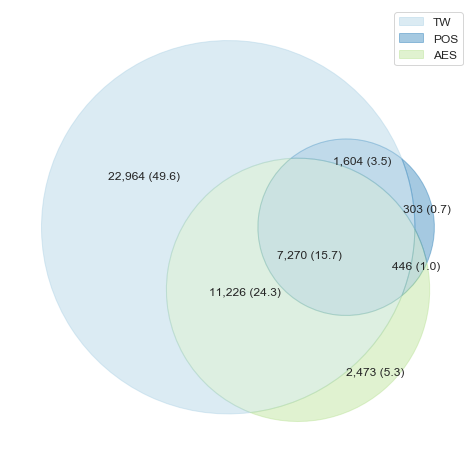

In [39]:
pdf = articles

total = len(am_shares.union(all_shares).union(twitter_set))

v = venn3([twitter_set, am_shares, all_shares],
      set_labels=('', '', ''),
      subset_label_formatter=lambda x: "{:,} ({:.1f})".format(x, 100*x/total));

v.get_patch_by_id('100').set_color(cp3[0])
v.get_patch_by_id('010').set_color(cp3[1])
v.get_patch_by_id('001').set_color(cp3[2])

v.get_patch_by_id('110').set_color(np.add(cp3[0], cp3[1])/2)
v.get_patch_by_id('011').set_color(np.add(cp3[1], cp3[2])/2)
v.get_patch_by_id('101').set_color(np.add(cp3[0], cp3[2])/2)

v.get_patch_by_id('111').set_color(np.add(np.add(cp3[1], cp3[0]), cp3[2]) / 3)

for text in v.set_labels:
    text.set_fontsize(10)
for text in v.subset_labels:
    text.set_fontsize(12)

plt.gca().legend(handles=[v.get_patch_by_id('100'), v.get_patch_by_id('010'), v.get_patch_by_id('001')],
                 labels=["TW", "POS", "AES"], prop={'size': 12});

#### Facebook coverage in detail


In [27]:
df = articles[['AES', 'POS']].dropna(how="all")
df = pd.concat([df, articles[['year']]], join="inner", axis=1)

x = df.groupby("year").apply(lambda x: sum(~x['AES'].isna() & x['POS'].isna())).to_frame("AES")
x = pd.concat([x, df.groupby("year").apply(lambda x: sum(~x['AES'].isna() & ~x['POS'].isna())).to_frame("AES and POS")], axis=1)
x = pd.concat([x, df.groupby("year").apply(lambda x: sum(x['AES'].isna() & ~x['POS'].isna())).to_frame("POS")], axis=1)

df_overlap_coverage = x.copy()
df_overlap_coverage.loc['All years'] = df_overlap_coverage.sum(axis=0).astype(int)
df_overlap_coverage['Any FB'] = df_overlap_coverage.sum(axis=1)

cols = ["AES", "AES and POS", "POS"]
for i in [2015, 2016, 2017, 'All years']:
    df_overlap_coverage.loc[i, cols] = df_overlap_coverage.loc[i, cols].map(
        lambda x: "{:,} ({:.1f}%)".format(x, 100*x/df_overlap_coverage.loc[i, "Any FB"]))
    
df_overlap_coverage.index.name = ""

if False:
    wks = sh.worksheet("Coverage - Facebook")
    set_with_dataframe(wks, df_overlap_coverage.reset_index())

df_overlap_coverage

,AES,AES and POS,POS,Any FB
,,,,
2015,"5,414 (57.6%)","3,182 (33.9%)",799 (8.5%),9395
2016,"4,540 (59.8%)","2,452 (32.3%)",606 (8.0%),7598
2017,"3,745 (59.2%)","2,082 (32.9%)",502 (7.9%),6329
All years,"13,699 (58.7%)","7,716 (33.1%)","1,907 (8.2%)",23322


#### Coverage by disciplines

In [28]:
articles['diff'] = articles['AES'] - articles['POS']
base = articles[~articles.disc.isin(["Arts", "Humanities"])]
print("Articles in Arts or Humanities:", articles[articles.disc.isin(["Arts", "Humanities"])].shape[0])

Articles in Arts or Humanities: 17


##### Coverage of disciplines

In [29]:
col = "disc"

cov_disciplines = base.groupby(col)[metrics].apply(lambda x: x.count())
cov_disciplines['All articles'] = base.groupby(col)[metrics].size()
cov_disciplines = cov_disciplines.sort_values("All articles", ascending=False)

# Column names + order
cov_disciplines.index.name = "Discipline"

In [30]:
# Format + Percentages
cov_disc_formatted = cov_disciplines.copy()
cov_disc_formatted.columns = [
    "AES (coverage)",
    "POS (coverage)",
    "TW (coverage)",
    "All articles (percentage)"]

cov_disc_formatted.loc['Total'] = cov_disc_formatted.sum()

cols = cov_disc_formatted.columns[0:3]
for i in cov_disc_formatted.index:
    cov_disc_formatted.loc[i, cols] = cov_disc_formatted.loc[i, cols].map(
        lambda x: "{:,} ({:.1f}%)".format(x, 100*x/cov_disc_formatted.loc[i, "All articles (percentage)"]))

t = cov_disc_formatted["All articles (percentage)"][:-1].sum()
cov_disc_formatted["All articles (percentage)"] = cov_disc_formatted["All articles (percentage)"].map(
    lambda x: "{:,} ({:.1f}%)".format(x, 100*x/t))
    
if False:
    wks = sh.worksheet("Disciplines - Coverage")
    set_with_dataframe(wks, cov_disc_formatted.reset_index())

cov_disc_formatted

,AES (coverage),POS (coverage),TW (coverage),All articles (percentage)
Discipline,,,,
Clinical Medicine,"9,668 (32.9%)","4,630 (15.8%)","20,387 (69.4%)","29,360 (50.7%)"
Biomedical Research,"4,554 (31.7%)","1,760 (12.3%)","10,379 (72.3%)","14,351 (24.8%)"
Biology,"3,069 (45.4%)","1,355 (20.0%)","5,150 (76.2%)","6,761 (11.7%)"
Psychology,"1,080 (64.2%)",515 (30.6%),"1,583 (94.2%)","1,681 (2.9%)"
Engineering and Technology,314 (26.5%),78 (6.6%),634 (53.6%),"1,183 (2.0%)"
Earth and Space,593 (54.0%),327 (29.8%),802 (73.0%),"1,098 (1.9%)"
Health,567 (52.6%),276 (25.6%),893 (82.9%),"1,077 (1.9%)"
Social Sciences,516 (70.5%),256 (35.0%),646 (88.3%),732 (1.3%)
Physics,261 (42.4%),73 (11.9%),424 (68.8%),616 (1.1%)


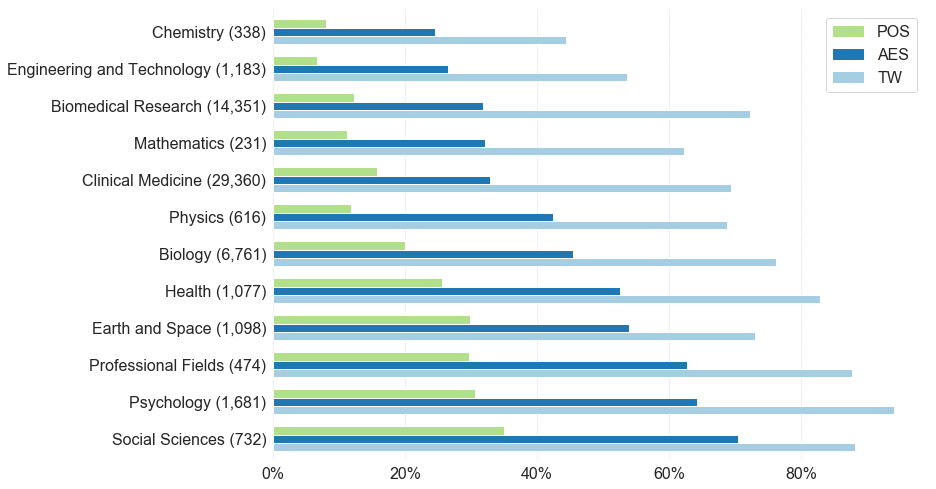

In [33]:
pdf = cov_disciplines[metrics].copy()
pdf = pdf.apply(lambda x: x.map(lambda y: 100*y/cov_disciplines.loc[x.name, "All articles"]), axis=1)
# pdf = pdf.sort_values("AES", ascending=False)

pdf.index = pdf.index.map(lambda x: "{} ({:,})".format(x, cov_disciplines.loc[x, "All articles"]))
pdf = pdf.sort_values(["AES"], ascending=False)
pdf = pdf[['POS', 'AES', "TW"][::-1]]

pdf.plot(kind="barh", colormap=ListedColormap(sns.color_palette("Paired", 3)), width=.65)

h, l = plt.gca().get_legend_handles_labels()
plt.legend(h[::-1], l[::-1])

plt.ylabel("")
plt.grid(False)
plt.grid(True, axis="x", linestyle=":")

ticks = plt.gca().get_xticks()[:-1]
plt.xticks(ticks, ["{}%".format(int(x)) for x in ticks])

sns.despine(top=True, bottom=True, left=True, right=True);

##### Distribution of disciplines

In [140]:
# Format + Percentages
cov_disc_formatted = cov_disciplines.copy()
cov_disc_formatted.columns = [
    "AES in % (rank)",
    "POS in % (rank)",
    "TW in % (rank)",
    "All articles in % (rank)"
]

for i in cov_disc_formatted.columns.tolist():
    ranks = cov_disc_formatted[i].rank(ascending=False)
#     cov_disc_formatted[i] = cov_disc_formatted[i].map(lambda x: "{:,} ({:.1f}%)".format(
#         int(x), 100*x/sum(cov_disc_formatted[i].iloc[:-1])))

    cov_disc_formatted[i] = cov_disc_formatted[i].map(lambda x: "{:.1f}%".format(
        100*x/sum(cov_disc_formatted[i].iloc[:-1])))
    
    cov_disc_formatted[i] = ["{} ({:,})".format(x, int(r)) for r, x in zip(ranks, cov_disc_formatted[i])]
    
if True:
    wks = sh.worksheet("Disciplines - Distributions")
    set_with_dataframe(wks, cov_disc_formatted.reset_index())
    
cov_disc_formatted

,AES in % (rank),POS in % (rank),TW in % (rank),All articles in % (rank)
Discipline,,,,
Clinical Medicine,46.0% (1),49.1% (1),49.2% (1),50.9% (1)
Biomedical Research,21.7% (2),18.6% (2),25.0% (2),24.9% (2)
Biology,14.6% (3),14.4% (3),12.4% (3),11.7% (3)
Psychology,5.1% (4),5.5% (4),3.8% (4),2.9% (4)
Engineering and Technology,1.5% (8),0.8% (9),1.5% (8),2.1% (5)
Earth and Space,2.8% (5),3.5% (5),1.9% (6),1.9% (6)
Health,2.7% (6),2.9% (6),2.2% (5),1.9% (7)
Social Sciences,2.5% (7),2.7% (7),1.6% (7),1.3% (8)
Physics,1.2% (10),0.8% (10),1.0% (9),1.1% (9)


##### Detailed look at Facebook

In [145]:
any_fb_counts = base.reindex(all_shares.union(am_shares))[col].value_counts()
any_fb_counts.loc['Total'] = any_fb_counts.sum()

In [152]:
a = all_shares.difference(am_shares)
b = all_shares.intersection(am_shares)
c = am_shares.difference(all_shares)

col = "disc"

indices = [a, b, c]

dfs = []
for ix, label in enumerate(["Only AES", "Both", "Only POS"]):
    x = base.reindex(indices[ix])[col].value_counts()
    dfs.append(x.to_frame(label))

pdf = pd.concat(dfs, axis=1, sort=False)
pdf.loc['Total'] = pdf.sum()

pdf['Any FB'] = pdf.sum(axis=1)
pdf['Public/Private (%)'] = np.round((pdf['Only POS'] + pdf['Both']) / (pdf['Only AES'] + pdf['Both']) * 100, 1)
pdf['POS/AES (%)'] = np.round(pdf['Only POS'] / (pdf['Only AES']) * 100, 1)

cols = pdf.columns[0:3]
for i in pdf.index:
    pdf.loc[i, cols] = pdf.loc[i, cols].map(
        lambda x: "{:,} ({:.1f}%)".format(x, 100*x/any_fb_counts[i]))

pdf.index.name = "Discipline"

if True:
    wks = sh.worksheet("Disciplines - FB")
    set_with_dataframe(wks, pdf[["Any FB", "Only AES", "Both", "Only POS"]].reset_index())
    
pdf.sort_values("Public/Private (%)")

,Only AES,Both,Only POS,Any FB,Public/Private (%),POS/AES (%)
Discipline,,,,,,
Engineering and Technology,255 (76.6%),59 (17.7%),19 (5.7%),333,24.8,7.5
Physics,198 (73.1%),63 (23.2%),10 (3.7%),271,28.0,5.1
Chemistry,63 (70.0%),20 (22.2%),7 (7.8%),90,32.5,11.1
Mathematics,53 (67.1%),21 (26.6%),5 (6.3%),79,35.1,9.4
Biomedical Research,"3,158 (64.2%)","1,396 (28.4%)",364 (7.4%),4918,38.6,11.5
Biology,"1,818 (57.3%)","1,251 (39.4%)",104 (3.3%),3173,44.2,5.7
Total,"13,464 (58.7%)","7,612 (33.2%)","1,852 (8.1%)",22928,44.9,13.8
Professional Fields,168 (54.4%),129 (41.7%),12 (3.9%),309,47.5,7.1
Psychology,620 (54.6%),460 (40.5%),55 (4.8%),1135,47.7,8.9


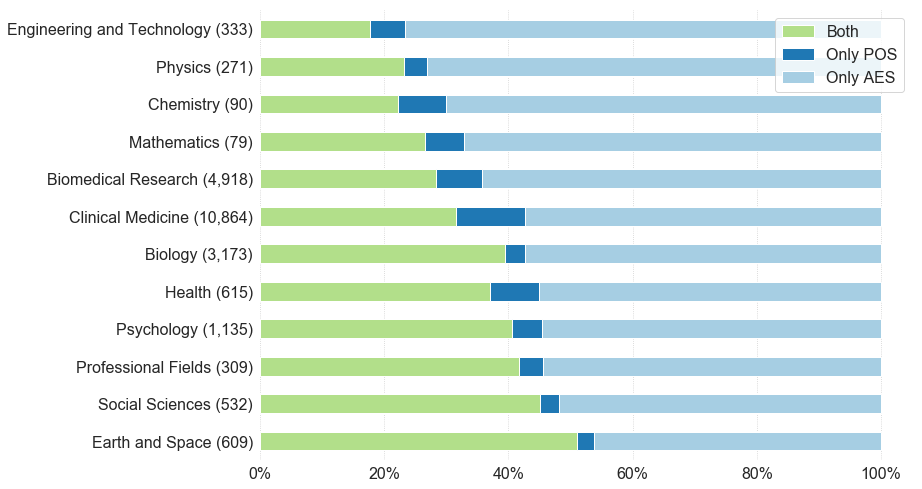

In [34]:
a = all_shares.difference(am_shares)
b = all_shares.intersection(am_shares)
c = am_shares.difference(all_shares)

col = "spec"
col = "disc"

any_fb_counts = base.reindex(all_shares.union(am_shares))[col].value_counts()
any_fb_counts.loc['Total'] = any_fb_counts.sum()

indices = [a, b, c]

dfs = []
for ix, label in enumerate(["Only AES", "Both", "Only POS"]):
    dois = set().union(*indices[ix:ix+1])
    x = base.reindex(dois)[col].value_counts()
    dfs.append(x.to_frame(label))

pdf = pd.concat(dfs, axis=1, sort=False)
pdf.index = pdf.index.map(lambda x: "{} ({:,})".format(x, any_fb_counts.loc[x]))

pdf = pdf.apply(lambda x: x.map(lambda y: 100*y/sum(x)), axis=1)
pdf = pdf.sort_values(by="Only AES")
pdf[['Both', 'Only POS', 'Only AES']].plot(kind="barh", stacked=True, colormap=ListedColormap(sns.color_palette("Paired", 3)[::-1]))

ticks = plt.gca().get_xticks()[:-1]
plt.xticks(ticks, ["{}%".format(int(x)) for x in ticks])

plt.grid(False)
plt.grid(True, axis="x", linestyle=":")
sns.despine(top=True, bottom=True, left=True, right=True)

### Engagement Counts

#### Comparison of AS, PS, and TW

In [53]:
binns = {}
alphas = {}

# straight line
def func(x, a, b):
    return a*x + b

for _ in ['AES', 'POS', 'TW']:
    data = articles[_].dropna()
    val_counts = data.value_counts().sort_index()
    
    x, y = partial_log_binning(val_counts, bin_size=0.1)
    
    binns[_] = x,y

    alpha, intercept = curve_fit(func, x, y)[0] # your data x, y to fit
    alphas[_] = np.abs(alpha)

/home/asura/.virtualenvs/altmetrics/lib/python3.5/site-packages/ipykernel_launcher.py:19: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/home/asura/.virtualenvs/altmetrics/lib/python3.5/site-packages/ipykernel_launcher.py:19: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/home/asura/.virtualenvs/altmetrics/lib/python3.5/site-packages/ipykernel_launcher.py:19: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


In [54]:
as_data = articles['AES'].dropna()
ps_data = articles['POS'].dropna()
tw_data = articles['TW'].dropna()

summary = pd.DataFrame()

# Base stats
summary['Count'] = articles[metrics].count()
summary['Min'] = articles[metrics].min()
summary['Max'] = articles[metrics].max()

# summary['Med'] = articles[metrics].median()
summary['Geom-Mean'] = [stats.gmean(as_data),
                        stats.gmean(ps_data),
                        stats.gmean(tw_data)]

# Fitted powerlaw
summary['α'] = [alphas['AES'], alphas['POS'], alphas['TW']]
summary.index.name = ""

if True:
    wks = sh.worksheet("Volumne - Distributions")
    set_with_dataframe(wks, summary.reset_index().round(2))

summary.round(2)

,Count,Min,Max,Geom-Mean,α
,,,,,
AES,21415,1.0,12473.0,2.36,1.95
POS,9623,1.0,186.0,1.53,2.54
TW,43064,1.0,8626.0,3.22,2.11


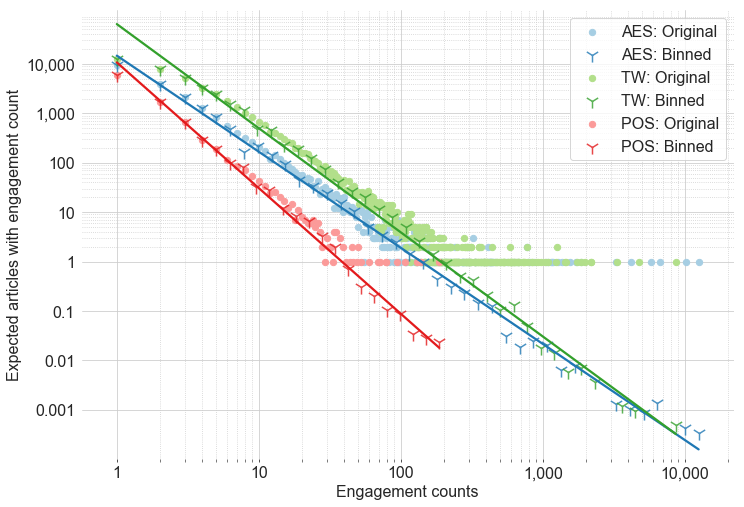

In [57]:
fig = plt.figure()
ax = plt.gca()

for ix, (m, (x,y)) in enumerate(list(binns.items())):
    data = {
        'x':x,
        'y':y
    }
    pdf = pd.DataFrame(data=data)
        
    val_counts = articles[m].dropna().value_counts()
    val_counts = np.log10(val_counts)
    val_counts.index = np.log10(val_counts.index)
    
    plt.scatter(x="index", y=m, data=val_counts.reset_index(),
                label="{}: Original".format(m), c=[cp10[2*ix]], alpha=1, s=40, marker="o",
                zorder=1)
    
    sns.regplot(x="x", y="y", data=pdf,
                label="{}: Binned".format(m), marker="1", color=cp10[2*ix+1],
                truncate=True, ci=False,
                scatter_kws={'s':200, 'zorder':2})
    
plt.legend()

plt.ylim(-4,5.1)
# plt.xlim(-.1,4)

xbins = [1, 10, 100, 1000, 10000]
plt.xticks(np.log10(xbins), ["{:,}".format(_) for _ in xbins]);

ybins = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
plt.yticks(np.log10(ybins), ["{:,}".format(_) for _ in ybins]);

min_ticks = [2,3,4,5,6,7,8,9]
min_ticks.extend([10*x for x in min_ticks[-8:]])
min_ticks.extend([10*x for x in min_ticks[-8:]])
min_ticks.extend([10*x for x in min_ticks[-8:]])
min_ticks.extend([10*x for x in min_ticks[-8:]])
min_ticks.extend([10*x for x in min_ticks[-8:]])

ax.tick_params(axis="x", which="both", bottom=True, length=3)
ax.tick_params(axis="y", which="both", bottom=True, length=3)

# locmin = ticker.LogLocator(subs=subs, numticks=200, numdecs=5)
locmin = ticker.FixedLocator(np.log10(min_ticks))

ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(ticker.NullFormatter())

ax.grid(axis="both", which="minor", linestyle=":")

ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(ticker.NullFormatter())

# plt.grid(False)

plt.ylabel("Expected articles with engagement count")
plt.xlabel("Engagement counts")

sns.despine(bottom=True, top=True, left=True, right=True, ax=ax)

In [156]:
articles[metrics].fillna(0).corr("spearman").round(2)

,AES,POS,TW
AES,1.00,0.48,0.45
POS,0.48,1.00,0.36
TW,0.45,0.36,1.00


#### Facebook counts in detail

In [167]:
print("AES > POS: {}".format(sum(articles['diff']>0)))
print("POS > AES: {}".format(sum(articles['diff']<0)))
print("AES == POS: {}".format(sum(articles['diff']==0)))

AES > POS: 5223
POS > AES: 466
AES == POS: 2027


In [170]:
5223+466+2027

7716

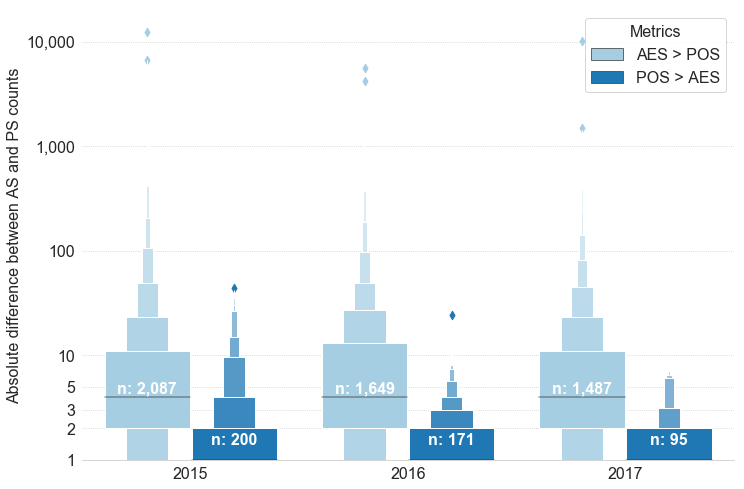

In [59]:
pdf = articles[['diff', 'year']].dropna()
pdf['year'] = pdf['year'].astype(str)
pdf = pdf[pdf['diff']!=0]

pdf["Metrics"] = pdf['diff']>0
pdf.Metrics.replace(True, "AES > POS", inplace=True)
pdf.Metrics.replace(False, "POS > AES", inplace=True)

pdf["diff"] = pdf["diff"].abs()

# sns.stripplot(x="year", y="diff", hue="metrics", dodge=True, data=pdf, palette=cm,
#              alpha=.4, edgecolor="black", linewidth=.3, size=3, jitter=True)

sns.boxenplot(x="year", y="diff", hue="Metrics", dodge=True, data=pdf, palette=cm,
             saturation=1)

medians = pdf.groupby(['year', 'Metrics'])['diff'].median().tolist()
nobs = pdf.groupby(['year', 'Metrics'])['diff'].count().tolist()
nobs = ["n: {:,}".format(x) for x in nobs]

pos = [-.2, .2, .8, 1.2, 1.8, 2.2]

for x, y, label in zip(pos, medians, nobs):
    plt.text(x, y+.4, label,
             horizontalalignment='center', color='w', weight='bold')

plt.yscale("log")
yticks = [1,2,3,5,10,100,1000,10000]
plt.yticks(yticks, ["{:,}".format(_) for _ in yticks]);
plt.ylim(1, plt.gca().get_ylim()[1]);
plt.ylabel("Absolute difference between AS and PS counts")
plt.xlabel("")

plt.grid(axis="y", linestyle=":")
plt.grid(False, axis="x")

sns.despine(left=True, right=True, top=True)

#### Counts by disciplines

In [35]:
a = base[base['diff']>0].index
b = base[base['diff']<0].index
c = base[base['diff']==0].index

indices = [a, b, c]

dfs = []
for ix, label in enumerate(["AES > POS", "AES < POS", "AES == POS"]):
    x = base.reindex(indices[ix]).copy()
    x['diff'] = np.abs(x['diff'])
    x = x.melt(id_vars="disc", value_vars=['diff'], value_name="Absolute difference between AES and POS")
    x['type'] = label
    dfs.append(x)
df = pd.concat(dfs, axis=0, sort=False)

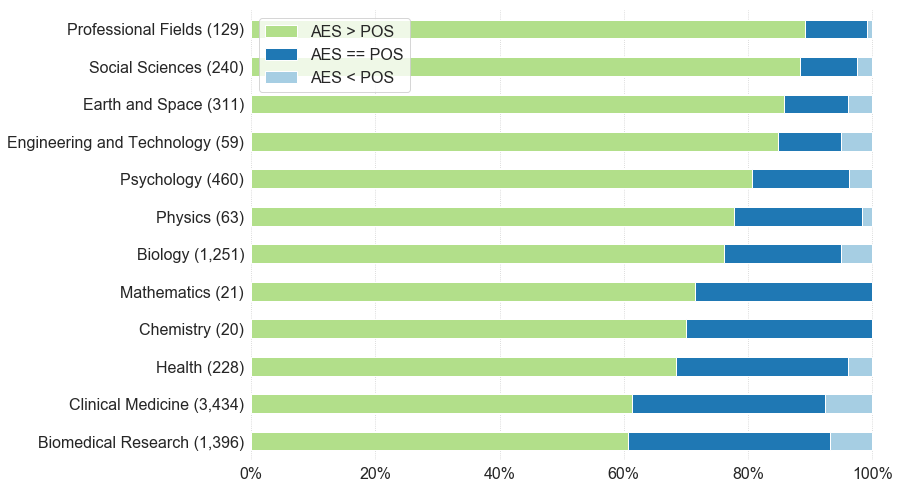

In [38]:
diff_disc_counts = base[~base['diff'].isna()].disc.value_counts()

pdf = df.groupby(["disc", "type"])['variable'].count().to_frame().reset_index()
y = df.groupby(["disc"])['variable'].count()

pdf['%'] = pdf.apply(lambda x: 100*x.variable/y[x.disc], axis=1)

pdf = pdf.pivot(index="disc", columns="type")['%']
pdf = pdf[['AES > POS', 'AES == POS', "AES < POS"]]
pdf = pdf.sort_values('AES > POS')

pdf.index = pdf.index.map(lambda x: "{} ({:,})".format(x, diff_disc_counts.loc[x]))

pdf.plot(kind="barh", stacked=True, colormap=ListedColormap(sns.color_palette("Paired", 3)[::-1]))

h, l = plt.gca().get_legend_handles_labels()
plt.legend(h, l)

ticks = plt.gca().get_xticks()[:-1]
plt.xticks(ticks, ["{}%".format(int(x)) for x in ticks])

plt.ylabel("")
plt.xlabel("")

plt.grid(False)
plt.grid(True, axis="x", linestyle=":")
sns.despine(top=True, bottom=True, left=True, right=True)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

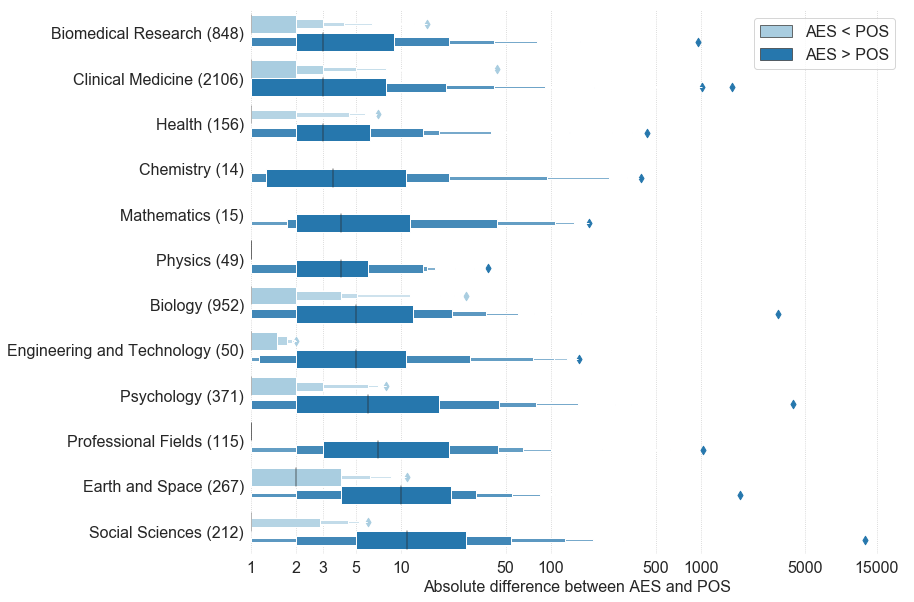

In [516]:
pdf = df.dropna()
pdf = pdf[pdf.type != "AES == POS"]
sort_med = pdf.groupby(["disc", "type"])['Absolute difference between AES and POS'].median().to_frame("median").groupby("disc")['median'].max()
pdf['sort'] = pdf.apply(lambda x: sort_med[x.disc], axis=1)

pdf = pdf.sort_values(["sort", "disc", "type"])

diff_disc_counts = base[base['diff']>0].disc.value_counts()
pdf.disc = pdf.disc.map(lambda x: "{} ({})".format(x, diff_disc_counts.loc[x]))


plt.figure(figsize=((11.69,10)))
sns.boxenplot(y="disc", x="Absolute difference between AES and POS", orient="h", hue="type", data=pdf, palette=cm, saturation=.9)
plt.xscale("log")

h, l = plt.gca().get_legend_handles_labels()
plt.legend(h, l)

plt.xlim(1, plt.gca().get_xlim()[1])

plt.ylabel("")
# plt.xticks(rotation=45, ha="right");

ticks = [1, 2, 3, 5, 10, 50, 100, 500, 1000, 5000, 15000]
plt.xticks(ticks, ticks)

plt.grid(axis="x", linestyle=":")
plt.grid(False, axis="y")

sns.despine(left=True, right=True, bottom=True, top=True)

# Dump

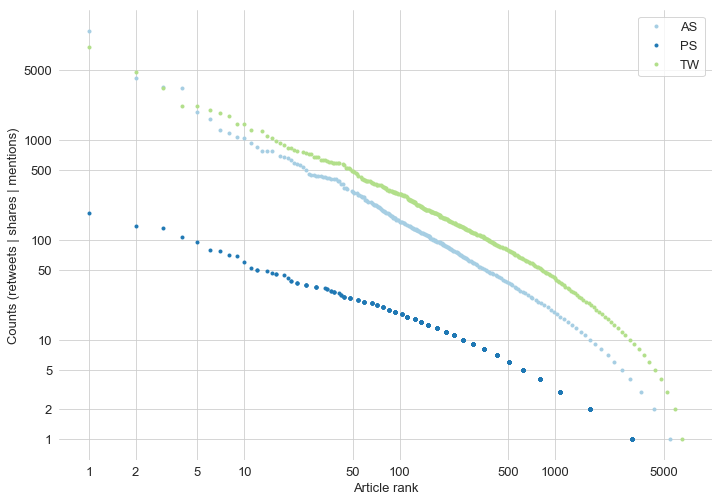

In [49]:
plot_cols = ['am_shares', 'all_shares', 'twitter']

pdf = metrics[plot_cols].dropna()

pdf = pd.concat([pdf, pdf.apply(lambda x: x.rank(ascending=False, method="min"))], axis=1)
pdf.columns = ['public-only', 'all', 'twitter', 'po_rank', 'all_rank', 'tw_rank']

pdf = pdf.apply(lambda x: x.map(lambda x: np.log10(x) if pd.notnull(x) else None))

fig, ax = plt.subplots()

alpha = 1
plt.plot(pdf['all_rank'].dropna().unique(),
         pdf['all'].dropna().unique(),
         '.', color=cp3[0], alpha=alpha, label="AS")
plt.plot(pdf['po_rank'].dropna(),
         pdf['public-only'].dropna(),
         '.', color=cp3[1], alpha=alpha, label="PS")
plt.plot(pdf['tw_rank'].dropna().unique(),
         pdf['twitter'].dropna().unique(),
         '.', color=cp3[2], alpha=alpha, label="TW")

ticks = [1, 2, 5, 10, 50, 100, 500, 1000, 5000]
plt.xticks(np.log10(ticks), ticks)
plt.yticks(np.log10(ticks), ticks)

plt.xlabel("Article rank")
plt.ylabel("Counts (retweets | shares | mentions)")

sns.despine(right=True, top=True, left=True, bottom=True, trim=False)

plt.legend();

/home/asura/.virtualenvs/altmetrics/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


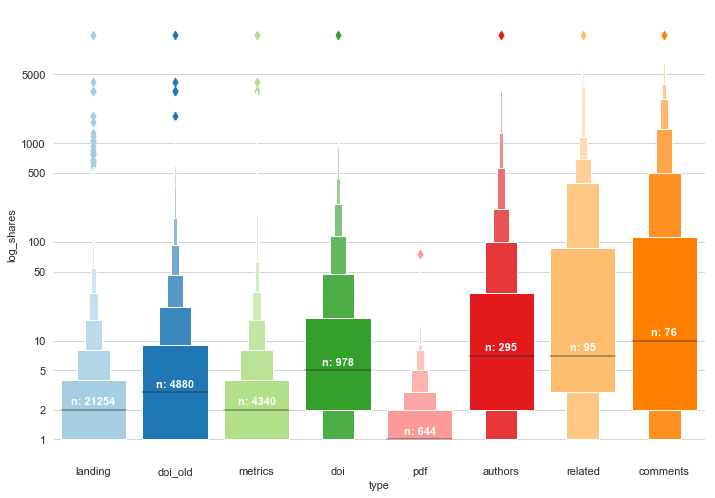

In [226]:
mask = nz_resp['type'].isin(["pmc", "pmid"])
pdf = nz_resp[~mask]
pdf['log_shares'] = pdf['shares'].map(lambda x: np.log10(x))

order = pdf.type.value_counts().keys().tolist()

ax = sns.boxenplot(x="type", y="log_shares", data=pdf,
                   saturation=1,
                   order=order, palette=cm)


medians = pdf.groupby(['type'])['log_shares'].median()
nobs = pdf['type'].value_counts()
nobs = nobs.map(lambda x: "n: {}".format(x))

pos = range(len(nobs))
for pos, label in enumerate(order):
    plt.text(pos, medians[label]+.05, nobs[label],
             horizontalalignment='center', color='w', weight='semibold')

ticks = [1, 2, 5, 10, 50, 100, 500, 1000, 5000]
plt.yticks(np.log10(ticks), ticks);

sns.despine(left=True, right=True, top=True, bottom=True);

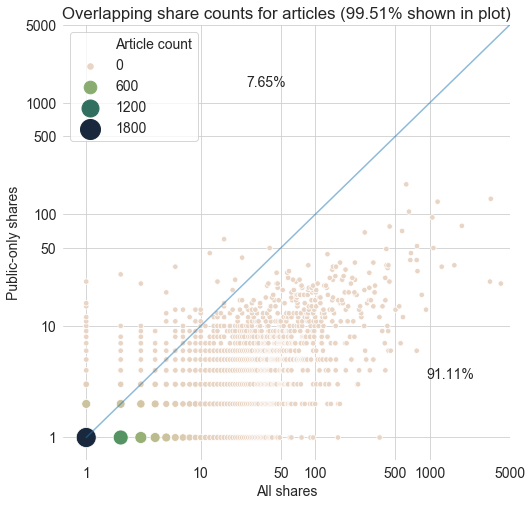

In [15]:
pdf = metrics[['am_shares', 'all_shares']].dropna()
pdf = pdf.merge(articles[['year']], left_index=True, right_index=True, how="left")
# pdf = pdf[pdf['all_shares'] != pdf['am_shares']]

# Log
pdf = np.log10(pdf)

# Add article count as columns
pdf = pdf.groupby(['am_shares', 'all_shares']).size().reset_index()

pdf.columns = ["Public-only shares", "All shares", "Article count"]

# Create fig and limits
plt.figure(figsize=(8,8))

fig_lim = 3.5
plt.ylim(-0.2,fig_lim);
plt.xlim(-0.2,fig_lim);

ax = plt.gca()
ax.plot(range(0,5), alpha=.5) # diagonal

cmap = sns.cubehelix_palette(8, start=.1, rot=-.75, as_cmap=True)
sns.scatterplot(x='All shares', y='Public-only shares', data=pdf,
                size="Article count", hue="Article count",
                sizes=(30, 400), palette=cmap, ax=ax);

# datapoints in plot area
dp_in_plot = pdf[(pdf['Public-only shares']<=fig_lim) & (pdf['All shares']<=fig_lim)]

# datapoints in left and right area
dp_in_left = pdf[pdf['Public-only shares']<pdf['All shares']]
dp_in_right = pdf[pdf['Public-only shares']>pdf['All shares']]

plt.title("Overlapping share counts for articles ({:.2f}% shown in plot)".format(100*len(dp_in_plot)/len(pdf)))
plt.text(0.4*fig_lim, 0.9*fig_lim, "{:.2f}%".format(100*len(dp_in_right)/len(pdf)))
plt.text(0.85*fig_lim, 0.15*fig_lim, "{:.2f}%".format(100*len(dp_in_left)/len(pdf)))

plt.ylabel('Public-only shares')
plt.xlabel('All shares')

sns.despine(left=True, top=True, bottom=True, right=True)

ticks = [1, 10, 50, 100, 500, 1000, 5000]
plt.xticks(np.log10(ticks), ticks)
plt.yticks(np.log10(ticks), ticks);